In [1]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load Model

Loading contents from file...


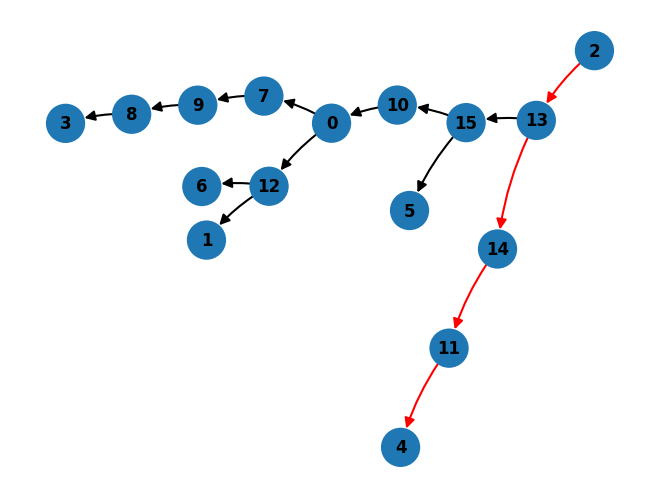

In [2]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

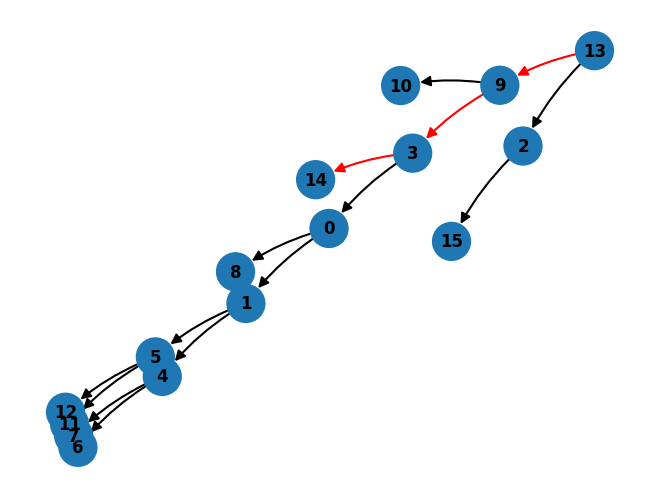

In [4]:
import random

random_seed = np.random.randint(1_000_000, 1_000_000_000)
pred = generate_example(n_states, random_seed, order="backward")
if is_model_correct(model, dataset, pred):
    parse_example(pred)
labels,cache = get_example_cache(pred, model, dataset)
labels= [f'N{i}_{component}' for i, component in enumerate(labels)]

In [5]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)


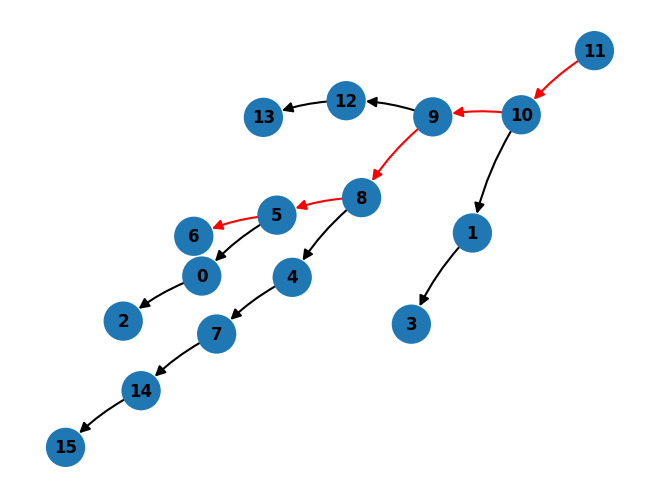

In [86]:
import random

random_seed = np.random.randint(1_000_000, 1_000_000_000)
pred = "14>15,0>2,7>14,5>6,5>0,4>7,12>13,8>5,8>4,9>12,9>8,1>3,10>9,10>1,11>10|6:11>10>9>8>5>6"
if is_model_correct(model, dataset, pred):
    parse_example(pred)
labels,cache = get_example_cache(pred, model, dataset)
labels= [f'N{i}_{component}' for i, component in enumerate(labels)]

In [87]:

for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

### Compare Subpaths to Full Path

In [6]:
def delete_non_paths(input_dict):
    keys_to_delete = [key for key, value in input_dict.items() if len(value) <= 2]
    for key in keys_to_delete:
        del input_dict[key]
    return input_dict

special_chars = [",", ":", "|"]
def get_paths(cache, labels, threshold=0.6):

    paths = {}
    for layer in range(1, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", "")
                    previous_token = labels[attended_pos - 1].replace(">", "")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token)
                        else:
                            paths[identifier] = [attended_token, previous_token]
    
    paths = delete_non_paths(paths)
    return paths

In [7]:
def get_paths_all_layers(cache, labels, threshold=0.1,delete_not_paths=True):

    paths = {}
    for layer in range(0, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", " ")
                    previous_token = labels[attended_pos - 1].replace(">", " ")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token+f"_layer{layer}")
                        else:
                            paths[identifier] = [attended_token+f"_layer{layer}", previous_token+f"_layer{layer}"]
    if(delete_not_paths):
        paths = delete_non_paths(paths)
    return paths

In [15]:
def get_attended_pos(cache, labels,positions,layers=range(0,6), threshold=0.1):
    paths = {}
    for layer in layers:
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in positions:       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos]
                    previous_token = labels[attended_pos - 1]
                    identifier = (current_pos, current_token)
                    if identifier in paths.keys():
                        paths[identifier].append(previous_token+f"_layer{layer}")
                    else:
                        paths[identifier] = [attended_token+f"_layer{layer}", previous_token+f"_layer{layer}"]
    return paths

In [39]:
def get_attended_pos_keys(cache, labels,positions,layers=range(0,6), threshold=0.1):
    paths = {}
    for layer in layers:
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in positions:       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", "")
                    previous_token = labels[attended_pos - 1].replace(">", "")
                    identifier = (current_pos, current_token)
                    if identifier in paths.keys():
                        paths[identifier].append(previous_token)
                    else:
                        paths[identifier] = [attended_token, previous_token]
    return paths

In [9]:
def can_construct_full_path(subpaths, full_path):
    # create a set of edges from the subpaths
    edges = set()
    for subpath in subpaths:
        for i in range(len(subpath) - 1):
            edges.add((subpath[i], subpath[i+1]))

    # create a set of edges required to traverse the full path
    required_edges = set()
    for i in range(len(full_path) - 1):
        required_edges.add((full_path[i], full_path[i+1]))

    # check if all required edges are in the set of edges from the subpaths
    return required_edges.issubset(edges)

['N0_14', 'N1_>8', 'N2_,', 'N3_12', 'N4_>14', 'N5_,', 'N6_6', 'N7_>12', 'N8_,', 'N9_5', 'N10_>6', 'N11_,', 'N12_0', 'N13_>15', 'N14_,', 'N15_0', 'N16_>5', 'N17_,', 'N18_2', 'N19_>0', 'N20_,', 'N21_3', 'N22_>2', 'N23_,', 'N24_9', 'N25_>3', 'N26_,', 'N27_7', 'N28_>9', 'N29_,', 'N30_4', 'N31_>7', 'N32_,', 'N33_11', 'N34_>13', 'N35_,', 'N36_10', 'N37_>4', 'N38_,', 'N39_1', 'N40_>11', 'N41_,', 'N42_1', 'N43_>10', 'N44_|', 'N45_8', 'N46_:', 'N47_1', 'N48_>10', 'N49_>4', 'N50_>7', 'N51_>9', 'N52_>3', 'N53_>2', 'N54_>0', 'N55_>5', 'N56_>6', 'N57_>12', 'N58_>14', 'N59_>8', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
14>8,12>14,6>12,5>6,0>15,0>5,2>0,3>2,9>3,7>9,4>7,11>13,10>4,1>11,1>10|8:1>10>4>7>9>3>2>0>5>6>12>14>8
atended_pos
{(36, '10'): ['6_layer0', ',_layer0', '5_layer1'], (38, ','): [',_layer0', '>9_layer0', '>4_layer1'], (39, '1'): ['14_layer0', ',_layer0', '9_layer1'], (42, '1'): ['11_layer0', ',_layer0', '1_layer1']}
['N0_9', 'N1_>4', 'N2_,', 'N3_0', 'N4_>9', 'N5_,', 'N6_14', 

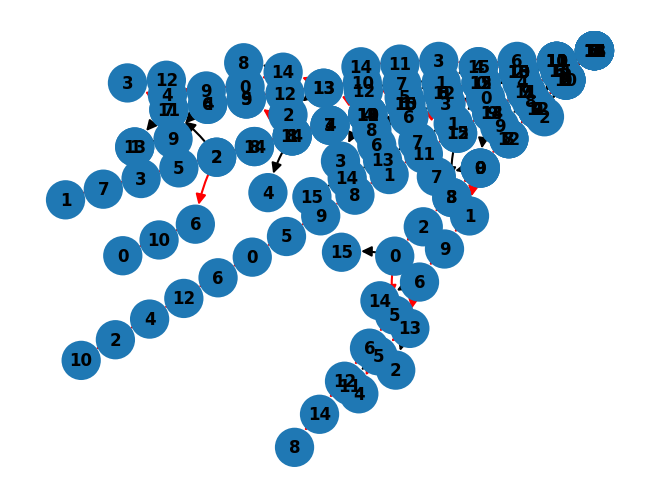

In [10]:
import random
n_examples = 10
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths_all = get_paths_all_layers(cache, labels,threshold=0.05,delete_not_paths=True)
    atended_pos=get_attended_pos(cache, labels,[36,38,39,42],layers=[0,1],threshold=0.1)
    subpaths = get_paths(cache, labels)
    print(graph_numbered)
    print(graph)
    #print(subpaths)
    #print(subpaths_all)
    print("atended_pos")
    print(atended_pos)
    parse_example(graph)


['N0_7', 'N1_>13', 'N2_,', 'N3_15', 'N4_>12', 'N5_,', 'N6_15', 'N7_>3', 'N8_,', 'N9_4', 'N10_>7', 'N11_,', 'N12_4', 'N13_>6', 'N14_,', 'N15_0', 'N16_>15', 'N17_,', 'N18_0', 'N19_>4', 'N20_,', 'N21_9', 'N22_>5', 'N23_,', 'N24_9', 'N25_>0', 'N26_,', 'N27_8', 'N28_>10', 'N29_,', 'N30_2', 'N31_>9', 'N32_,', 'N33_2', 'N34_>8', 'N35_,', 'N36_1', 'N37_>14', 'N38_,', 'N39_11', 'N40_>2', 'N41_,', 'N42_11', 'N43_>1', 'N44_|', 'N45_12', 'N46_:', 'N47_11', 'N48_>2', 'N49_>9', 'N50_>0', 'N51_>15', 'N52_>12', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
7>13,15>12,15>3,4>7,4>6,0>15,0>4,9>5,9>0,8>10,2>9,2>8,1>14,11>2,11>1|12:11>2>9>0>15>12
node position >6 13
node position >12 4
atended_pos_36:{(36, '1'): ['>15_layer1', '0_layer1', '9_layer1']}

['N0_9', 'N1_>14', 'N2_,', 'N3_12', 'N4_>9', 'N5_,', 'N6_3', 'N7_>12', 'N8_,', 'N9_15', 'N10_>3', 'N11_,', 'N12_4', 'N13_>10', 'N14_,', 'N15_1', 'N16_>15', 'N17_,', 'N18_1', 'N19_>4', 'N2

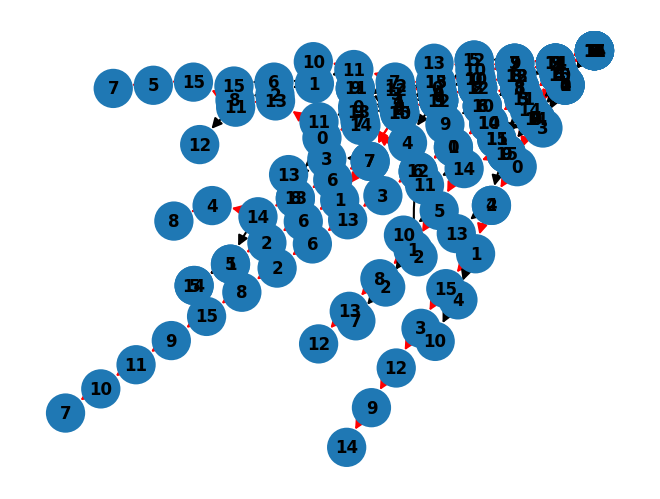

In [11]:

#plotting examples where filtered_position is not there.
node_filter=">6"
node_filter2=">12"#should be a list
import random
n_examples = 10
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    node_position=-1
    for i, component in enumerate(graph_split):
        if dataset.idx2tokens[component] == node_filter:
           node_position = i
           break
    node_position2=-1
    for i, component in enumerate(graph_split):
        if dataset.idx2tokens[component] == node_filter2:
           node_position2 = i
           break    

    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths_all = get_paths_all_layers(cache, labels,threshold=0.05,delete_not_paths=True)
    atended_pos=get_attended_pos(cache, labels,[38,39,42],layers=[0,1],threshold=0.1)
    atended_pos_36=get_attended_pos(cache, labels,[36],layers=[0,1],threshold=0.1)
    subpaths = get_paths(cache, labels)
    print(graph_numbered)
    print(graph)
    #print(subpaths)
    #print(subpaths_all)
    print(f"node position >6 {node_position}")
    print(f"node position >12 {node_position2}")
    print(f'atended_pos_36:{atended_pos_36}')
    print("")
    #print(f'atended_pos:{atended_pos}')
    
    parse_example(graph)

In [72]:
def subpath_filtered(n_examples,subpath_position=36,threshold=0.3,subpath_layers_to_print=[1],print_position_token=">6",node_filter="6",not_in_subpath=True):
    for _ in range(n_examples):

        # get example
        random_seed = np.random.randint(1_000_000, 1_000_000_000)
        graph = generate_example(n_states, random_seed, order="backward")
        full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
        full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
        graph_split = dataset.tokenize(graph)
        graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
        node_position=-1
        for i, component in enumerate(graph_split):
            if dataset.idx2tokens[component] == print_position_token:
                node_position = i
                break
        # get cache
        prediction, is_correct = eval_model(model, dataset, graph)
        labels, cache = get_example_cache(prediction, model, dataset)

        # get subpaths and reverse (as the model is backtracking)
        subpaths = get_paths(cache, labels)
        subpaths_filter = get_attended_pos_keys(cache, labels,[subpath_position],layers=[1],threshold=threshold)
        subpaths_print = get_attended_pos_keys(cache, labels,[subpath_position],layers=subpath_layers_to_print,threshold=threshold)
        filter_node=""
        for path in subpaths_filter.values():
            filter_node =path
        if (node_filter in filter_node) ^ not_in_subpath:
            print(f'{print_position_token}_position {node_position}')
            print(f'filter_subpaths={subpaths_print}')
            print(graph_numbered)
            print(graph)
            parse_example(graph)
            plt.show()

>6_position 43
filter_subpaths={(36, '7'): ['0', '3']}
['N0_8', 'N1_>10', 'N2_,', 'N3_2', 'N4_>8', 'N5_,', 'N6_14', 'N7_>13', 'N8_,', 'N9_14', 'N10_>2', 'N11_,', 'N12_0', 'N13_>4', 'N14_,', 'N15_0', 'N16_>1', 'N17_,', 'N18_5', 'N19_>15', 'N20_,', 'N21_3', 'N22_>14', 'N23_,', 'N24_3', 'N25_>0', 'N26_,', 'N27_11', 'N28_>5', 'N29_,', 'N30_11', 'N31_>3', 'N32_,', 'N33_7', 'N34_>12', 'N35_,', 'N36_7', 'N37_>11', 'N38_,', 'N39_9', 'N40_>7', 'N41_,', 'N42_9', 'N43_>6', 'N44_|', 'N45_13', 'N46_:', 'N47_9', 'N48_>7', 'N49_>11', 'N50_>3', 'N51_>14', 'N52_>13', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
8>10,2>8,14>13,14>2,0>4,0>1,5>15,3>14,3>0,11>5,11>3,7>12,7>11,9>7,9>6|13:9>7>11>3>14>13


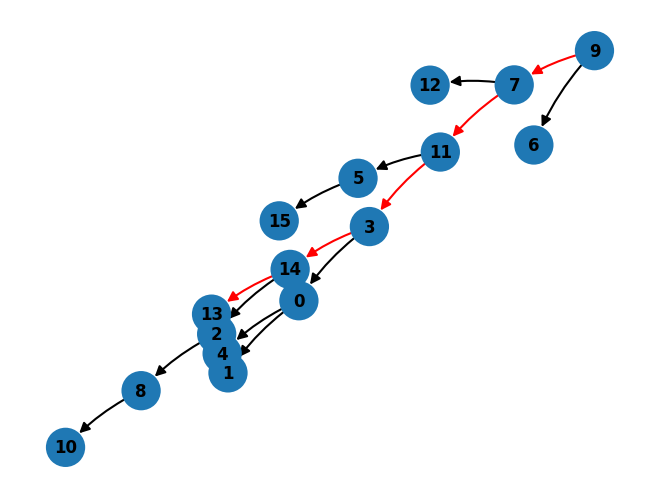

>6_position 22
filter_subpaths={}
['N0_5', 'N1_>1', 'N2_,', 'N3_13', 'N4_>5', 'N5_,', 'N6_11', 'N7_>13', 'N8_,', 'N9_7', 'N10_>11', 'N11_,', 'N12_4', 'N13_>7', 'N14_,', 'N15_15', 'N16_>4', 'N17_,', 'N18_9', 'N19_>15', 'N20_,', 'N21_9', 'N22_>6', 'N23_,', 'N24_0', 'N25_>9', 'N26_,', 'N27_14', 'N28_>0', 'N29_,', 'N30_3', 'N31_>14', 'N32_,', 'N33_10', 'N34_>3', 'N35_,', 'N36_10', 'N37_>2', 'N38_,', 'N39_12', 'N40_>10', 'N41_,', 'N42_8', 'N43_>12', 'N44_|', 'N45_1', 'N46_:', 'N47_8', 'N48_>12', 'N49_>10', 'N50_>3', 'N51_>14', 'N52_>0', 'N53_>9', 'N54_>15', 'N55_>4', 'N56_>7', 'N57_>11', 'N58_>13', 'N59_>5', 'N60_>1', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
5>1,13>5,11>13,7>11,4>7,15>4,9>15,9>6,0>9,14>0,3>14,10>3,10>2,12>10,8>12|1:8>12>10>3>14>0>9>15>4>7>11>13>5>1


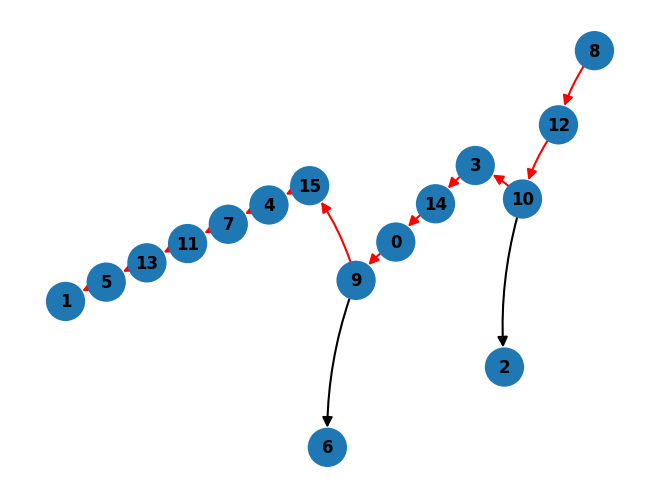

>6_position 37
filter_subpaths={}
['N0_1', 'N1_>14', 'N2_,', 'N3_1', 'N4_>7', 'N5_,', 'N6_11', 'N7_>13', 'N8_,', 'N9_11', 'N10_>12', 'N11_,', 'N12_9', 'N13_>15', 'N14_,', 'N15_0', 'N16_>5', 'N17_,', 'N18_0', 'N19_>1', 'N20_,', 'N21_6', 'N22_>11', 'N23_,', 'N24_6', 'N25_>9', 'N26_,', 'N27_4', 'N28_>2', 'N29_,', 'N30_4', 'N31_>0', 'N32_,', 'N33_3', 'N34_>8', 'N35_,', 'N36_3', 'N37_>6', 'N38_,', 'N39_10', 'N40_>4', 'N41_,', 'N42_10', 'N43_>3', 'N44_|', 'N45_2', 'N46_:', 'N47_10', 'N48_>4', 'N49_>2', 'N50_,', 'N51_,', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
1>14,1>7,11>13,11>12,9>15,0>5,0>1,6>11,6>9,4>2,4>0,3>8,3>6,10>4,10>3|2:10>4>2


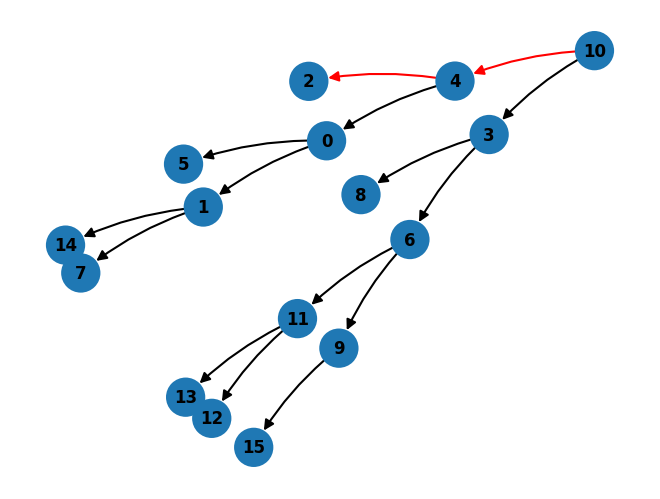

In [73]:
subpath_filtered(10,subpath_position=36,print_position_token=">6",node_filter="6",not_in_subpath=True,subpath_layers_to_print=[1])

>10_position 43
filter_subpaths={(38, ','): [',', '9']}
['N0_14', 'N1_>15', 'N2_,', 'N3_0', 'N4_>2', 'N5_,', 'N6_7', 'N7_>14', 'N8_,', 'N9_5', 'N10_>6', 'N11_,', 'N12_5', 'N13_>0', 'N14_,', 'N15_4', 'N16_>7', 'N17_,', 'N18_12', 'N19_>13', 'N20_,', 'N21_8', 'N22_>5', 'N23_,', 'N24_8', 'N25_>4', 'N26_,', 'N27_9', 'N28_>12', 'N29_,', 'N30_9', 'N31_>8', 'N32_,', 'N33_1', 'N34_>3', 'N35_,', 'N36_10', 'N37_>9', 'N38_,', 'N39_10', 'N40_>1', 'N41_,', 'N42_11', 'N43_>10', 'N44_|', 'N45_6', 'N46_:', 'N47_11', 'N48_>10', 'N49_>9', 'N50_>8', 'N51_>5', 'N52_>6', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
14>15,0>2,7>14,5>6,5>0,4>7,12>13,8>5,8>4,9>12,9>8,1>3,10>9,10>1,11>10|6:11>10>9>8>5>6


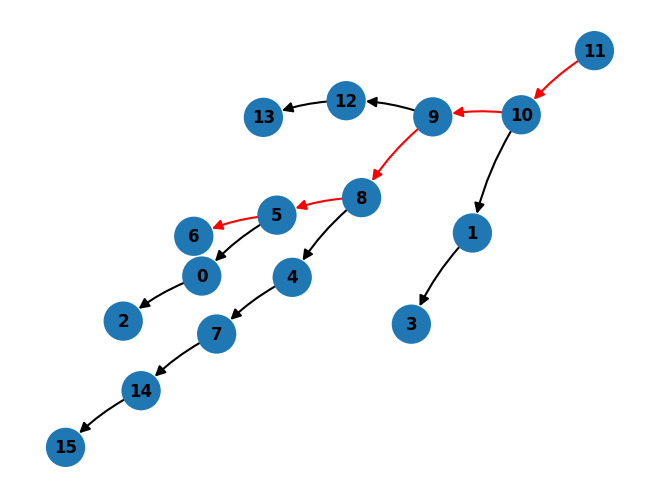

>10_position -1
filter_subpaths={(38, ','): [',', '0']}
['N0_8', 'N1_>13', 'N2_,', 'N3_5', 'N4_>8', 'N5_,', 'N6_4', 'N7_>5', 'N8_,', 'N9_14', 'N10_>15', 'N11_,', 'N12_2', 'N13_>9', 'N14_,', 'N15_3', 'N16_>6', 'N17_,', 'N18_3', 'N19_>4', 'N20_,', 'N21_11', 'N22_>14', 'N23_,', 'N24_11', 'N25_>2', 'N26_,', 'N27_0', 'N28_>3', 'N29_,', 'N30_0', 'N31_>1', 'N32_,', 'N33_12', 'N34_>11', 'N35_,', 'N36_12', 'N37_>0', 'N38_,', 'N39_10', 'N40_>12', 'N41_,', 'N42_10', 'N43_>7', 'N44_|', 'N45_15', 'N46_:', 'N47_10', 'N48_>12', 'N49_>11', 'N50_>14', 'N51_>15', 'N52_,', 'N53_,', 'N54_,', 'N55_,', 'N56_,', 'N57_,', 'N58_,', 'N59_,', 'N60_,', 'N61_,', 'N62_,', 'N63_,', 'N64_,', 'N65_,']
8>13,5>8,4>5,14>15,2>9,3>6,3>4,11>14,11>2,0>3,0>1,12>11,12>0,10>12,10>7|15:10>12>11>14>15


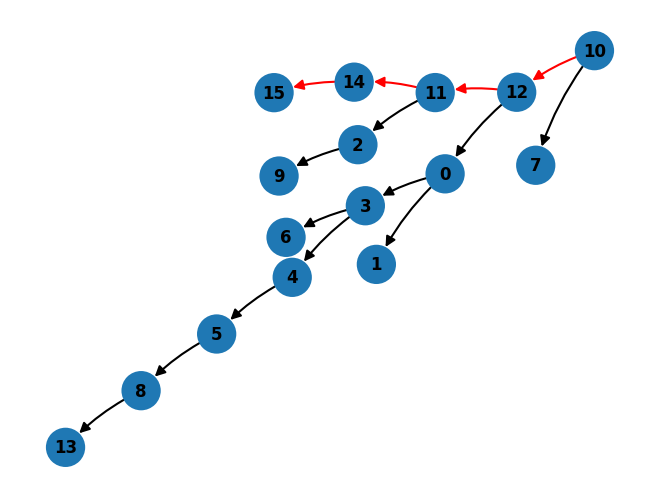

In [84]:
subpath_filtered(20,subpath_position=38,print_position_token=">10",node_filter="10",not_in_subpath=True,subpath_layers_to_print=[1,2,3])

In [11]:
import random
n_examples = 300
subpaths_all_forward =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="forward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_forward.append(subpaths)


In [12]:
import random
n_examples = 300
subpaths_all_backward =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_backward.append(subpaths)

In [13]:
import random
n_examples = 300
subpaths_all_random =[]
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="random")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point
    full_pat_numbered =indexed_components = [f'{i}_ {component}' for i, component in enumerate(full_path)]
    graph_split = dataset.tokenize(graph)
    graph_numbered =[f'N{i}_{dataset.idx2tokens[component]}' for i, component in enumerate(graph_split)]
    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    #print(graph_numbered)
    #print((subpaths))
    
    subpaths_all_random.append(subpaths)


In [14]:
from collections import Counter
results={}
for subpath in subpaths_all_random:
    for key, value in subpath.items():
        if key[0] in results:
            results[key[0]].append(value[0])
        elif key[0]<47:
            results[key[0]]=[]
            results[key[0]].append(value[0])

for key, value in results.items():
    occurrences = Counter(value)
    total_count = len(value)
    percentages= []
    for key_occ, value_occ in occurrences.items():
        percentage = (value_occ / total_count) * 100
        percentages.append(f"{key_occ}: {percentage:.2f}%")

    print(f'{key}: total{total_count} {percentages}')

34: total135 ['4: 8.15%', '1: 7.41%', '6: 6.67%', '0: 6.67%', '5: 6.67%', '10: 5.93%', '15: 5.93%', '2: 8.15%', '11: 5.93%', '13: 4.44%', '3: 5.19%', '8: 8.15%', '9: 5.93%', '12: 3.70%', '7: 6.67%', '14: 4.44%']
37: total155 ['5: 11.61%', '6: 6.45%', '3: 10.32%', '0: 10.32%', '11: 5.16%', '10: 5.81%', '7: 3.87%', '9: 7.10%', '8: 7.10%', '2: 5.81%', '14: 1.29%', '13: 5.16%', '1: 7.10%', '15: 4.52%', '12: 5.16%', '4: 3.23%']
38: total178 ['10: 100.00%']
41: total203 ['2: 79.80%', '0: 18.23%', '15: 0.99%', '6: 0.49%', '5: 0.49%']
43: total237 ['1: 9.70%', '10: 4.64%', '5: 5.91%', '11: 5.06%', '8: 3.80%', '12: 4.64%', '6: 8.44%', '7: 7.17%', '3: 9.28%', '4: 7.59%', '2: 10.97%', '0: 4.64%', '9: 5.91%', '15: 4.22%', '14: 3.38%', '13: 4.64%']
44: total213 ['1: 86.85%', '15: 7.51%', '5: 2.82%', '14: 0.94%', '10: 0.47%', '13: 0.94%', '12: 0.47%']
45: total218 ['4: 91.74%', '12: 2.29%', '7: 0.46%', '14: 1.83%', '6: 0.92%', '0: 1.38%', '5: 0.46%', '15: 0.46%', '1: 0.46%']
46: total38 ['11: 2.63%'

In [15]:
from collections import Counter
existing_keys=[]
for i,subpath in enumerate(subpaths_all):
    existing_keys.append([])
    for (key,value_2), value in subpath.items():
        existing_keys[i].append(key)

for key in existing_keys:
    print(key)


AttributeError: 'tuple' object has no attribute 'items'

In [ ]:
from collections import Counter
existing_keys=[]
for subpath in subpaths_all:
    for (key,key_value), value in subpath.items():
        existing_keys.append(key)


element_counts = Counter(existing_keys)
    # Calculate the total number of elements
total_lists = len(subpaths_all)
    
    # Print the percentage of each element
for element, count in element_counts.items():
        percentage = (count / total_lists) * 100
        print(f"Element {element}: {percentage:.2f}%")


: 

In [ ]:
from collections import Counter
existing_keys=[]
for subpath in subpaths_all_random:
    for (key,key_value), value in subpath.items():
        existing_keys.append(key)


element_counts = Counter(existing_keys)
    # Calculate the total number of elements
total_lists = len(subpaths_all)
    
    # Print the percentage of each element
for element, count in element_counts.items():
        percentage = (count / total_lists) * 100
        print(f"Element {element}: {percentage:.2f}%")



: 

In [ ]:
total_lists

: 

In [ ]:
import random

def remove_duplicates(list_of_lists):
    unique_data = set(map(tuple, list_of_lists))
    return list(map(list, unique_data))

n_examples = 200
outputs = {}
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="forward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point

    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    reversed_subpaths = [subpath[::-1] for subpath in list(subpaths.values())]
    reversed_subpaths = remove_duplicates(reversed_subpaths)
    
    # check if full path can be constructed from subpaths
    full_path_in_subpaths = can_construct_full_path(reversed_subpaths, full_path)
    outputs[random_seed] = {
        "graph": graph,
        "prediction": prediction,
        "is_correct": is_correct,
        "full_path_in_subpaths": full_path_in_subpaths,
        "full_path": "full_path",
        "reversed_subpaths": reversed_subpaths,
    }

: 

In [ ]:
for g in outputs.values():
    if not g["full_path_in_subpaths"]:
        print(g["graph"])
        parse_example(g["graph"])
        print(g["reversed_subpaths"])

: 

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from tree_generation.viz import hierarchy_pos

def parse_example(example_str: str, reversed_subpaths: list = []):
    # ... [existing code]

    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    node_edge_sizes = [0 for i in range(len(nodes))]
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    pos = hierarchy_pos(G)
    new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
    nx.draw(
        G,
        pos=new_pos,
        font_weight="bold",
        connectionstyle='arc3, rad = 0.1',
        with_labels=True,
        edgecolors="darkgoldenrod",
        linewidths=node_edge_sizes,
        arrowsize=15,
        width=1.5,
        node_size=800,
        edge_color=[G[u][v]['color'] for u, v in G.edges()]
    )

    # Now, draw the circles for reversed_subpaths
    radius_increment = 0.007  # Increment radius for each subpath
    base_radius = 0.05       # Starting radius for the circles
    colors = ['blue', 'green', 'yellow', 'purple', 'orange',"brown","pink"]  # Add more colors if needed

    for i, subpath in enumerate(reversed_subpaths):
        for node in subpath:
            node_pos = new_pos[int(node)]
            circle = plt.Circle(node_pos, base_radius + i * radius_increment, color=colors[i % len(colors)], fill=False)
            plt.gca().add_artist(circle)

    plt.show()


example =outputs[list(outputs.keys())[1]]
print(example["graph"])
print( example["reversed_subpaths"][:][0])

parse_example(example["graph"], example["reversed_subpaths"][:][:])


: 

In [ ]:
example["subpaths"]

: 

In [ ]:
import torch
import os

def load_lenses(directory="lenses"):
    lenses = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pt"):
            key = filename[:-3]  # Remove the ".pt" extension
            filepath = os.path.join(directory, filename)
            lenses[key] = torch.load(filepath)
    return lenses

lenses= load_lenses()

def logit_lens_all_probs(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    current_node = int(labels[position].split(">")[-1])
    current_neighbors = [f">{i}" for i in range(dataset.n_states)]
    # Get the logit lens for each layer's resid_post
    probs = {key: [] for key in current_neighbors}
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.softmax(-1)
        for key in probs:
            key_prob = out_proj[position, dataset.tokens2idx[key]].item()
            probs[key].append(key_prob)
    # Plot data
    for key in probs:
        plt.plot(probs[key], label=key)
    plt.xlabel("Layer")
    plt.ylabel(f"Probability of Token")
    plt.title(f"Probability of Correct Token at {labels[position]}")
    plt.legend()
    plt.show()
    # Return result
    return probs

probs = logit_lens_all_probs(example["graph"], model, dataset, 48, lenses=lenses)

: 

In [ ]:
logit_lens(example["graph"], model, dataset, lenses=lenses)

: 

In [ ]:
is_not_corrects = [(k, v) for k, v in outputs.items() if v["full_path_in_subpaths"] == False]
is_not_corrects

: 

In [ ]:
is_corrects = [v["is_correct"] for k, v in outputs.items()]
print(f"is_corrects: {sum(is_corrects) / len(is_corrects)}")

full_path_in_subpathss = [v["full_path_in_subpaths"] for k, v in outputs.items()]
print(f"full_path_in_subpathss: {sum(full_path_in_subpathss) / len(full_path_in_subpathss)}")

: 

### Subpath Probing

### Attention Head Visualization

In [ ]:
import re

def replace_numbers_with_characters(strings_list):
    result = []
    for string in strings_list:
        # Find all numbers in the string
        numbers = re.findall(r'\d+', string)
        if numbers:
            # Assume there is exactly one number in the string
            number = int(numbers[0])
            # Check if the number is within the range 0-25
            if 0 <= number <= 25:
                # Convert the number to the corresponding alphabet character
                char = chr(ord('A') + number)
                # Replace the number with the character
                new_string = string.replace(numbers[0], char)
                # Add a space in front of each character
                spaced_string = ' '.join(new_string)
                result.append(spaced_string)
            else:
                print(f"The number {number} in string '{string}' is out of range (0-25).")
                # Add a space in front of each character
                spaced_string = ' '.join(string)
                result.append(spaced_string)
        else:
            # Add a space in front of each character
            spaced_string = ' '.join(string)
            result.append(spaced_string)
    return result

def display_head(cache, labels, layer, head, show=False):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    last_idx = average_patterns.shape[-1] - 1
    while labels[last_idx] == ",":
        last_idx -= 1
    last_idx += 1
    path_start_pos = labels.index(":") + 1
    edge_list_end_post = labels.index("|")

    matrix = average_patterns[0, head, path_start_pos:last_idx, :edge_list_end_post].cpu()
    labels = [l.replace(">", "\u2192") for l in labels]
    labels = replace_numbers_with_characters(labels)
    
    labels_y = labels[path_start_pos:last_idx]
    labels_x = labels[:edge_list_end_post]
    fig = px.imshow(
        matrix,
        labels=dict(x="Previous Token attended to", y="Correct Next Step", color="Value"),
        color_continuous_scale="Blues",
        zmin=0,
        zmax=1,
        aspect="auto"
    )
    
    layout = dict(
        width=1200,
        height=400,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels_x,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels_y,
        )
    )
    fig.update_layout(layout)
    if show:
        fig.show()
    else:
        return fig
    
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache[1], cache[0], l, h, show=False)
        fig.write_image(f'./images/attn_{l}_{h}.png')

: 

In [ ]:
average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
        last_idx = average_patterns.shape[-1] - 1
        while labels[last_idx] == ",":
            last_idx -= 1
        last_idx += 1
        path_start_pos = labels.index(":") + 1
        edge_list_end_post = labels.index("|")

        matrix = average_patterns[0, head, path_start_pos:last_idx, :edge_list_end_post].cpu()
        labels = [l.replace(">", "\u2192") for l in labels]
        labels = replace_numbers_with_characters(labels)
        
        labels_y = labels[path_start_pos:last_idx]
        labels_x = labels[:edge_list_end_post]
        

: 

In [ ]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache[1], cache[0], l, h, show=True)

: 

In [ ]:
cache[1].keys()

: 

### Probing Dataset

In [ ]:
#act_names = ["ln_final.hook_normalized"]
#act_names += [f"blocks.{i}.ln2.hook_normalized" for i in range(model.cfg.n_layers)]
act_names = [f"blocks.4.ln1.hook_normalized"]
#act_names += [f"blocks.{i}.mlp.hook_post" for i in range(model.cfg.n_layers)]
import random
model.reset_hooks()

def aggregate_activations(model, dataset, activation_keys, n_samples, order, path_length=None):
    act_cache = {ak: [] for ak in activation_keys}
    graphs = []
    for _ in range(n_samples):
        example_graph = generate_example(
            n_states=dataset.n_states,
            seed=random.randint(300_000, 1_000_000_000),
            path_length=path_length,
            order=order
        )
        correct = is_model_correct(model, dataset, example_graph)
        if not correct:
            continue
        _, cache = get_example_cache(example_graph, model, dataset)
        graphs.append(example_graph)
        for key in activation_keys:
            act_cache[key].append(cache[key].cpu())
    return act_cache, graphs

activations_file = "activations_L4_ln1_normalized.pt"
if not os.path.exists(activations_file):
    print("Generating activations ...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=64_000,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=8_000,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , activations_file)
else:
    print("loading activations ... ")
    acts, graphs, test_acts, test_graphs = torch.load(activations_file)


: 

In [ ]:
def extract_transposed_adj_matrix(example_str, power=1):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray().T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

: 

In [ ]:
def extract_transposed_adj_matrix_only_path(example_str, power=1, transposed=False):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            G.add_edge(edge[0], edge[1])
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray()
    if transposed:
        adjacency = adjacency.T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

: 

In [ ]:
import numpy as np
import networkx as nx

def extract_transposed_adj_matrix_only_path(example_str, N, power=1, transposed=False):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node, in_node = map(int, e.split(">"))
        edgelist.append((out_node, in_node))
        nodes.update([out_node, in_node])
    
    # Extract path
    goal = example_str.split("|")[1]
    goal_node, path_str = goal.split(":")
    goal_node = int(goal_node)
    path = list(map(int, path_str.split(">")))
    
    # Only include the last N edges from the goal in the path
    if N > 0:
        path = path[-(N+1):]
    
    path_edges = list(zip(path[:-1], path[1:]))
    
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist, f"Edge {edge} not in edgelist"
    
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for edge in edgelist:
        if edge in path_edges:
            G.add_edge(*edge)
    
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray()
    if transposed:
        adjacency = adjacency.T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency


: 

In [ ]:
acts.keys()

: 

: 

In [ ]:
def return_probing_dataset(acts, graphs):
    X = {key: [] for key in acts.keys()}
    y = []
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        # get adjacency matrix of only path
        y.append(extract_transposed_adj_matrix_only_path(graph, None).flatten())
        # Iterate over all layers residual streams
        for key in X.keys():
            # streams = acts[key][gidx][0, start_idx-1:start_idx]  # only pos 47
            streams = acts[key][gidx][0, start_idx-1:start_idx]
            X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    y = np.array(y)
    return X, y


dataX, y = return_probing_dataset(acts, graphs)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs)

: 

In [ ]:
from sklearn.model_selection import train_test_split

len(dataX["blocks.4.hook_resid_post"])
dataX, dataXTest, y, y_test = train_test_split(dataX["blocks.4.hook_resid_post"], y, test_size=0.2, random_state=42)


len(dataX)
len(dataXTest)

: 

### Nonlinear Probing

In [ ]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

import warnings
warnings.filterwarnings("ignore")


probe = probing.NonlinearMultiClsProbe(max_iter=1000, verbose=True, learning_rate_init=1e-3)
probe.fit(dataX, y.astype(np.float32))
print(probe.score(dataX, y))

answers = (probe.predict(dataXTest) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

: 

In [ ]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

: 

In [ ]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

for label in acts.keys():
    print(label)

    X = dataX[label]
    X_test = dataXTest[label]

    probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True)
    probe.fit(X, y.astype(np.float32))
    print(probe.score(X, y))

    answers = (probe.predict(X_test) > 0.5)
    y_pred = answers.flatten()
    y_true = y_test.flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print('Accuracy: {:.2f}%'.format(accuracy*100))
    print('Precision: {:.2f}%'.format(precision*100))
    print('Recall: {:.2f}%'.format(recall*100))

: 

: 

In [ ]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

: 

### Sparse Coding + Linear Probing

In [ ]:

coder = SparseCoder(4096, max_iter=5_000, batch_size=8192, l1_coef=0.001, learning_rate_init=3e-4, verbose=True)
coder.fit(X)

: 

In [ ]:
from sparse_coding import *

d_model = dataX['blocks.4.hook_resid_post'].shape[-1]
coder = SparseCoder(num_codes=4*d_model, verbose=True)

# train
coder.fit(dataX['blocks.4.hook_resid_post'])
torch.save(coder.model.state_dict(), f'sae_resid_post_4.pt')


: 

In [ ]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

probe = probing.NonlinearMultiClsProbe(max_iter=600, verbose=True)
features = coder.featurize(X.astype(np.float32))
probe.fit(features, y.astype(np.float32))
print(probe.score(features,y.astype(np.float32)))
feats = coder.featurize(X_test)

: 

In [ ]:
linear_probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True)
features = coder.featurize(X.astype(np.float32))
linear_probe.fit(features, y.astype(np.float32))
print(linear_probe.score(features,y.astype(np.float32)))
feats = coder.featurize(X_test)

: 

In [ ]:
answers = (probe.predict(feats )> 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

: 

In [ ]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

: 